In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

plt.style.use('ggplot')

In [7]:
df = pd.read_csv('Mall_Customers.csv', index_col = [0])
df

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40
...,...,...,...,...
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74


# Explore data

In [6]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [8]:
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [11]:
df.duplicated().sum()

0

<Figure size 1200x400 with 0 Axes>

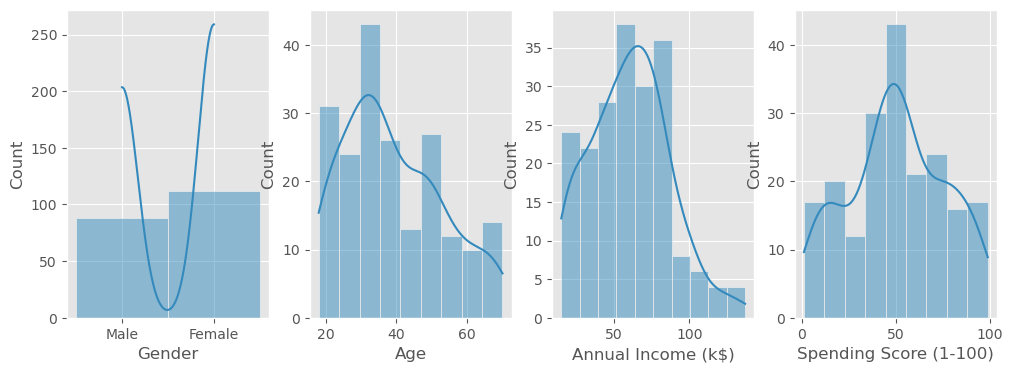

In [13]:
# Set the background color and figsize
plt.figure(figsize = (12, 4))

# Adjust subplot vertical spacing
plt.subplots_adjust(hspace = 0.2)

# 7x2 subplot figure
fig, axs = plt.subplots(1, 4, figsize = (12, 4))

i = 1
# Loop through dataframe columns
for feature in df.columns:
    # Create a subplot
    plt.subplot(1, 4, i)
    # Create histogram
    sns.histplot(data = df, x = feature, kde = True)
    i += 1
    
# Show the plot
plt.show()

Conclusion:
1. Data clean
2. Distribution not ideal for ML => need to do skewness analysis and OneHotEncoder, StandardScaler before fit to model

In [14]:
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.preprocessing import StandardScaler


def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.histplot(x, ax=ax[0,0], kde = True)
    sns.histplot(np.log(x), ax=ax[0,1], kde = True)
    sns.histplot(np.sqrt(x), ax=ax[1,0], kde = True)
    sns.histplot(stats.boxcox(x)[0], ax=ax[1,1], kde = True)
    plt.tight_layout()
    plt.show()
    
    print("original knew value", x.skew().round(2))
    print("log knew value", np.log(x).skew().round(2))
    print("sqrt knew value", np.sqrt(x).skew().round(2))
    print("boxcox knew value", pd.Series(stats.boxcox(x)[0]).skew().round(2))

In [15]:
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)
df

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
CustomerID,,,,
1,19,15,39,1
2,21,15,81,1
3,20,16,6,0
4,23,16,77,0
5,31,17,40,0
...,...,...,...,...
196,35,120,79,0
197,45,126,28,0
198,32,126,74,1


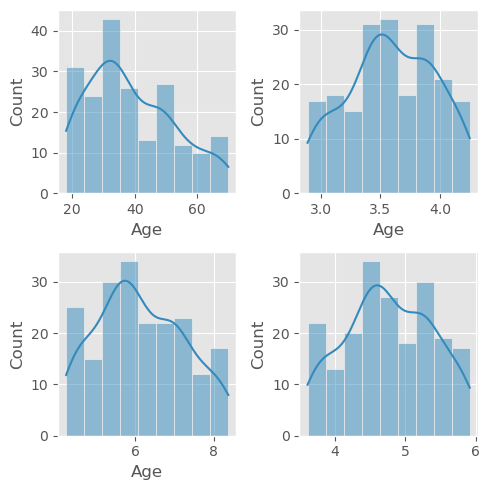

original knew value 0.49
log knew value -0.11
sqrt knew value 0.2
boxcox knew value -0.02


In [16]:
analyze_skewness(df["Age"])

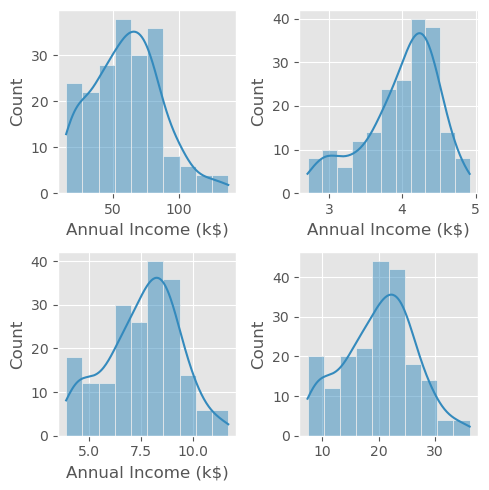

original knew value 0.32
log knew value -0.76
sqrt knew value -0.23
boxcox knew value -0.07


In [17]:
analyze_skewness(df["Annual Income (k$)"])

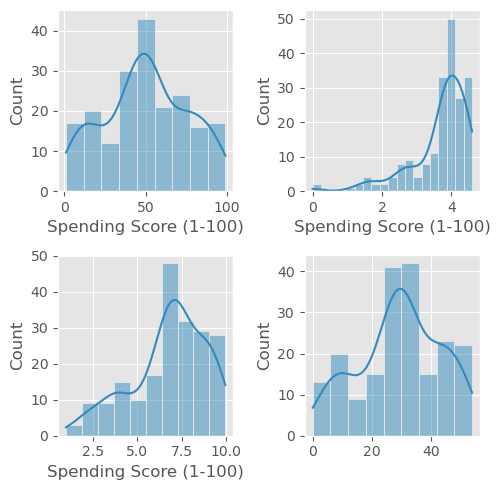

original knew value -0.05
log knew value -1.81
sqrt knew value -0.71
boxcox knew value -0.24


In [18]:
analyze_skewness(df["Spending Score (1-100)"])

In [27]:
# From knewness analysis, we need to use boxcox for Age, Income, and keep original data for Spending
df_transform = df.copy()
df_transform['Age'] = stats.boxcox(df['Age'])[0]
df_transform['Annual Income (k$)'] = stats.boxcox(df['Annual Income (k$)'])[0]
df_transform['Spending Score (1-100)'] = df['Spending Score (1-100)']
df_transform

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
CustomerID,,,,
1,3.691442,7.409624,39,1
2,3.847430,7.409624,81,1
3,3.771098,7.793130,6,0
4,3.991239,7.793130,77,0
5,4.476951,8.168337,40,0
...,...,...,...,...
196,4.680657,33.053921,79,0
197,5.114323,34.169044,28,0
198,4.529888,34.169044,74,1


In [29]:
from sklearn.preprocessing import MinMaxScaler
# Transform numeric data to range 0:1
scaler = MinMaxScaler()
df_transform[['Age','Annual Income (k$)','Spending Score (1-100)']] \
    = scaler.fit_transform(df_transform[['Age','Annual Income (k$)','Spending Score (1-100)']])

df_transform

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
CustomerID,,,,
1,0.036083,0.000000,0.387755,1
2,0.103643,0.000000,0.816327,1
3,0.070582,0.013336,0.051020,0
4,0.165927,0.013336,0.775510,0
5,0.376293,0.026384,0.397959,0
...,...,...,...,...
196,0.464520,0.891765,0.795918,0
197,0.652344,0.930543,0.275510,0
198,0.399220,0.930543,0.744898,1


# Choose K

C:\Users\vy\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


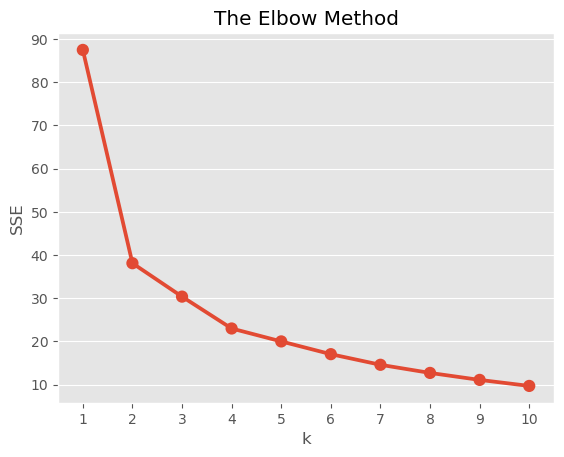

In [30]:
from sklearn.cluster import KMeans

sse = {}

for k in range (1,11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(df_transform)
    sse[k] = kmeans.inertia_
    
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot (x = list(sse.keys()), y = list(sse.values()))
plt.show()

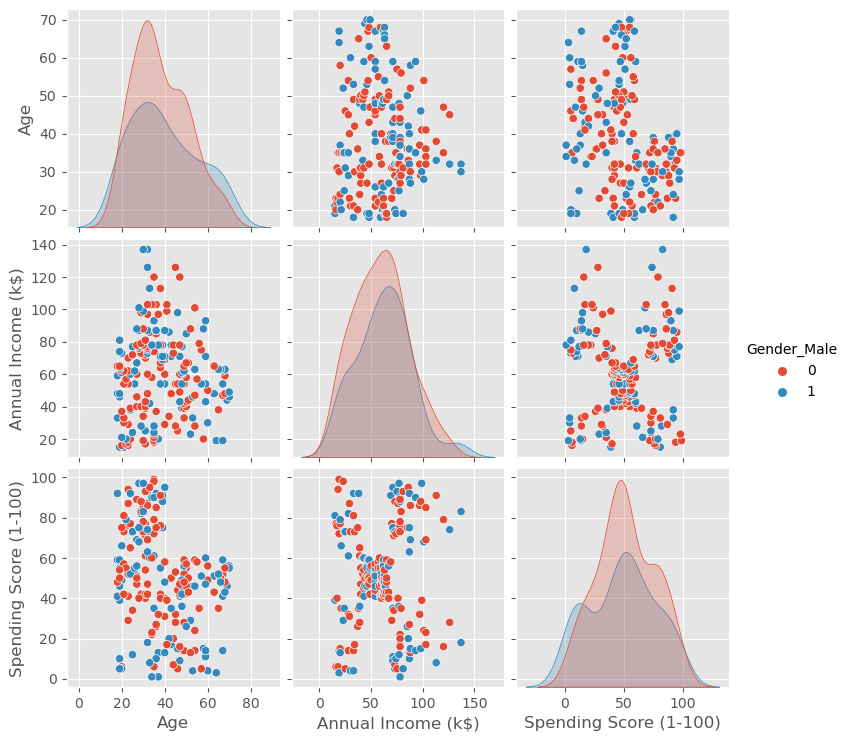

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(df,
            vars = ['Age','Annual Income (k$)','Spending Score (1-100)'],
            hue = 'Gender_Male')
plt.show()

In [35]:
# Build Model with k = 3
model = KMeans(n_clusters = 3, random_state = 42)
model.fit(df_transform)


KMeans(n_clusters=3, random_state=42)

In [36]:
# Done create model. Now add cluster name to original df
df['Cluster'] = model.labels_
df.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Cluster
CustomerID,,,,,
1,19,15,39,1,0
2,21,15,81,1,0
3,20,16,6,0,1
4,23,16,77,0,1
5,31,17,40,0,1
6,22,17,76,0,1
7,35,18,6,0,1
8,23,18,94,0,1
9,64,19,3,1,2


In [37]:
# Finally: print out parameter of 3 clusters
final = df.groupby('Cluster').agg(
        {'Age':'mean',
        'Annual Income (k$)' : 'mean',
        'Spending Score (1-100)' : 'mean'
        }).round(2)
final

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,27.63,62.98,67.14
1,38.10,59.25,51.53
2,51.44,61.51,30.71


In [38]:
from mpl_toolkits import mplot3d
%matplotlib inline


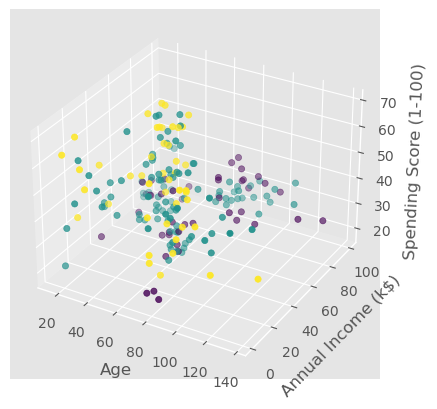

In [39]:
ax = plt.axes(projection='3d')

#scatter datas
zdata = df['Age']
xdata = df['Annual Income (k$)']
ydata = df['Spending Score (1-100)']
marker = df['Cluster']
ax.scatter3D(xdata, ydata, zdata, c = marker)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Annual Income (k$)', fontsize=12)
ax.set_zlabel('Spending Score (1-100)', fontsize=12)

plt.show()

# Choose k = 4

In [40]:
model_1 = KMeans(n_clusters = 4, random_state = 42)
model_1.fit(df_transform)

KMeans(n_clusters=4, random_state=42)

In [43]:
# Done create model. Now add cluster name to original df
df['Cluster'] = model_1.labels_
df.head(10)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,Cluster
CustomerID,,,,,
1,19,15,39,1,1
2,21,15,81,1,1
3,20,16,6,0,0
4,23,16,77,0,0
5,31,17,40,0,0
6,22,17,76,0,0
7,35,18,6,0,2
8,23,18,94,0,0
9,64,19,3,1,3


In [44]:
# Finally: print out parameter of 4 clusters
final = df.groupby('Cluster').agg(
        {'Age':'mean',
        'Annual Income (k$)' : 'mean',
        'Spending Score (1-100)' : 'mean'
        }).round(2)
final

,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,28.09,58.74,66.77
1,27.63,62.98,67.14
2,48.47,59.78,35.73
3,51.44,61.51,30.71


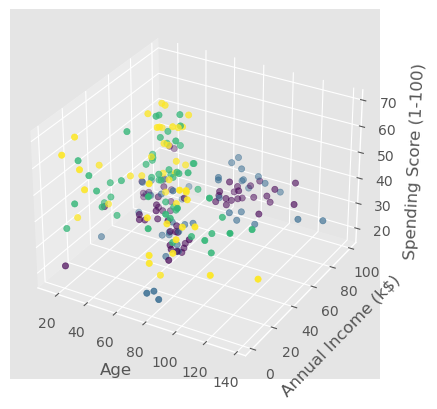

In [45]:
ax = plt.axes(projection='3d')

#scatter datas
zdata = df['Age']
xdata = df['Annual Income (k$)']
ydata = df['Spending Score (1-100)']
marker = df['Cluster']
ax.scatter3D(xdata, ydata, zdata, c = marker)

ax.set_xlabel('Age', fontsize=12)
ax.set_ylabel('Annual Income (k$)', fontsize=12)
ax.set_zlabel('Spending Score (1-100)', fontsize=12)

plt.show()